## Notebook de modélisation des données - Projet 3 - David Depouez

### 1. Généralités

Selection de la cible pour ce Notebook => **Energie**

In [1]:
isEnergyTarget = True

if isEnergyTarget == True:
    targetName = 'SiteEnergyUse(kBtu)'
else:
    targetName = 'TotalGHGEmissions'

Importation des modules et lecture du fichier de données

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import shap

In [3]:
path = "./data/cleaned/"

filename = "Cleaned-2016_Building_Energy_Benchmarking.csv"
#filename = "FinalCleaned-2016_Building_Energy_Benchmarking.csv"
#filename = "EssaiCleaned-2016_Building_Energy_Benchmarking.csv"

df = pd.read_csv(path+filename)
df.shape

(1650, 46)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   YearBuilt                    1650 non-null   float64
 1   NumberofBuildings            1650 non-null   float64
 2   NumberofFloors               1650 non-null   float64
 3   PropertyGFATotal             1650 non-null   float64
 4   ENERGYSTARScore              1650 non-null   float64
 5   SourceEUI(kBtu/sf)           1650 non-null   float64
 6   SiteEnergyUse(kBtu)          1650 non-null   float64
 7   SteamUse(kBtu)               1650 non-null   float64
 8   Electricity(kBtu)            1650 non-null   float64
 9   NaturalGas(kBtu)             1650 non-null   float64
 10  TotalGHGEmissions            1650 non-null   float64
 11  BALLARD                      1650 non-null   float64
 12  CENTRAL                      1650 non-null   float64
 13  DELRIDGE          

Séparation du jeu de donnés pour l'apprentissage

In [5]:
from sklearn.model_selection import train_test_split

dfTrain, dfTest = train_test_split(df, train_size=0.8,random_state=42)
dfTrain.shape , dfTest.shape

((1320, 46), (330, 46))

### 2. Modélisations avec l'Energy Star Score

In [6]:
XTrain = dfTrain.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1 )
yTrain = dfTrain[targetName].copy()
XTest = dfTest.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1 )
yTest = dfTest[targetName].copy()

On centre et on met à l'echelle les données

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

xTrainScaled = scaler.fit_transform(XTrain)
xTestScaled = scaler.transform(XTest)

On définit une fonction pour retourner différentes metriques

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

def getRegressionMetrics(ypredict, yreel,isDump = True) :
    ### Compute MSE, RMSE and R2  ###
    MSE = mean_squared_error(yreel, ypredict)
    RMSE = mean_squared_error(yreel, ypredict, squared=False)
    R2 = r2_score(yreel, ypredict)
    if isDump == True :
        print("MSE {:.2f} RMSE {:.2f} R2 {:.3f}".format(MSE,RMSE,R2))
    return (MSE, RMSE, R2)

#### Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression()
linear_regr.fit(xTrainScaled, yTrain)

yPredTrain = linear_regr.predict(xTrainScaled)
yPredTest = linear_regr.predict(xTestScaled)

In [10]:
msTrain,rmTrain,r2Train  = getRegressionMetrics(yPredTrain, yTrain)
msTest,rmTest,r2Test  = getRegressionMetrics(yPredTest, yTest)

MSE 5427738739575.85 RMSE 2329750.79 R2 0.778
MSE 6490946090049.83 RMSE 2547733.52 R2 0.757


In [11]:
# Store errors
Results = []
Results.append(['Linear Regression',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### RidgeCV

In [12]:
from sklearn.linear_model import RidgeCV

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

ridgeCV_regr = RidgeCV(alphas=alphas,
scoring='neg_mean_squared_error',
                 cv=fold_number)
ridgeCV_regr.fit(xTrainScaled, yTrain)
print('alpha = {}  best score = {}'.format(ridgeCV_regr.alpha_ , ridgeCV_regr.best_score_))
yPredtrain = ridgeCV_regr.predict(xTrainScaled)
print('Train best score = {}'.format(ridgeCV_regr.score(xTrainScaled,yTrain)))
yPredTest = ridgeCV_regr.predict(xTestScaled)
print('Test best score = {}'.format(ridgeCV_regr.score(xTestScaled,yTest)))
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredtrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

alpha = 599.4842503189409  best score = -7405050011772.564
Train best score = 0.7466080324658826
Test best score = 0.6879183844255654
MSE 6193806015417.68 RMSE 2488735.83 R2 0.747
MSE 8338293614452.63 RMSE 2887610.36 R2 0.688


In [13]:
# Store errors
Results.append(['RidgeCV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Ridge  with Manual CV

In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from numpy import mean , std

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

In [15]:
TabErrors = []
ridge_regr = Ridge()

for i,a in enumerate(alphas) :
    ridge_regr.set_params(alpha=a)
    scores = cross_validate(ridge_regr, xTrainScaled, yTrain, cv=fold_number,
                            scoring=('neg_mean_squared_error','neg_root_mean_squared_error','r2'))
    temp = a, -mean(scores['test_neg_mean_squared_error']), -mean(scores['test_neg_root_mean_squared_error']), mean(scores['test_r2'])
    TabErrors.append(temp)

#mini = [val[0] for i,val in enumerate(TabErrors) if val[1] == np.min(TabErrors,axis=0)[1]]
#mini

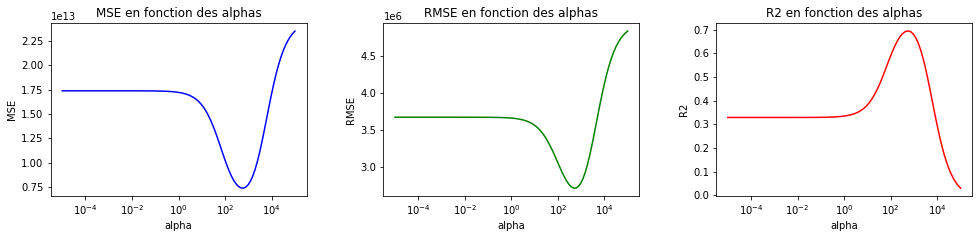

In [16]:
fig, axes = plt.subplots(1, 3,figsize=(16,3))
tab = ['MSE','RMSE','R2']
color = ['b','g','r']

for i,error_name in enumerate(tab) :
    error_liste = [name[i+1] for j,name in enumerate(TabErrors)]
    axes[i].plot(alphas,  error_liste,c=color[i])
    axes[i].set_xscale('log')
    axes[i].set_xlabel('alpha')
    axes[i].set_ylabel(error_name)
    axes[i].set_title(tab[i] + ' en fonction des alphas')
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, 
                    wspace=0.3, hspace=0.2)

plt.show()

Get best params

In [17]:
dfErrors = pd.DataFrame(TabErrors,columns=['alpha','MSE','RMSE','R2'])
imin = dfErrors['R2'].idxmax()
print('Index values for MSE {}, RMSE {},  R2 {}'
      .format(dfErrors['MSE'].idxmax(),dfErrors['MSE'].idxmax(),imin  )   )
alphaBest = dfErrors.loc[imin,'alpha']
print('Best fit is for alpha = {}'.format(alphaBest))

Index values for MSE 99, RMSE 99,  R2 77
Best fit is for alpha = 599.4842503189409


Apply model with best params

In [18]:
ridge_regr.set_params(alpha=alphaBest)
ridge_regr.fit(xTrainScaled, yTrain)
yPredTrain = ridge_regr.predict(xTrainScaled)
yPredTest = ridge_regr.predict(xTestScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 6193806015417.68 RMSE 2488735.83 R2 0.747
MSE 8338293614452.63 RMSE 2887610.36 R2 0.688


In [19]:
# Store errors
Results.append(['Ridge with Manual CV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### LassoCV

In [20]:
from sklearn.linear_model import LassoCV

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

lassoCV_regr = LassoCV(alphas=alphas, cv=fold_number)

lassoCV_regr.fit(xTrainScaled, yTrain)
print('Best fit is for alpha = {}'.format(lassoCV_regr.alpha_))
yPredtrain = lassoCV_regr.predict(xTrainScaled)
print('Train best score = {:.3f}'.format(lassoCV_regr.score(xTrainScaled,yTrain)))
yPredTest = lassoCV_regr.predict(xTestScaled)
print('Test best score = {:.3f}'.format(lassoCV_regr.score(xTestScaled,yTest)))
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredtrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

Best fit is for alpha = 100000.0
Train best score = 0.766
Test best score = 0.750
MSE 5727646814636.59 RMSE 2393250.26 R2 0.766
MSE 6678012526355.32 RMSE 2584185.08 R2 0.750


In [21]:
# Store errors
Results.append(['LassoCV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Lasso with Manual CV

In [22]:
from sklearn.linear_model import Lasso

n_alphas = 100
alphas = np.logspace(-3, 4, n_alphas)

In [23]:
TabErrors = []
lasso_regr = Lasso()

for i,a in enumerate(alphas) :
    lasso_regr.set_params(alpha=a)
    scores = cross_validate(lasso_regr, xTrainScaled, yTrain, cv=fold_number,
                            scoring=('neg_mean_squared_error','neg_root_mean_squared_error','r2'))
    temp = a, -mean(scores['test_neg_mean_squared_error']), -mean(scores['test_neg_root_mean_squared_error']), mean(scores['test_r2'])
    TabErrors.append(temp)


Objective did not converge. You might want to increase the number of iterations. Duality gap: 341001479306092.0, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 371701278800860.5, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 397847362309514.5, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 301784087414294.5, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 403534811086132.5, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 341001533623558.0, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 371701303825785.0, tolerance: 2632331717772.0674


Objective did not converge. You might want to increase the number of iterations. Duality gap: 341001531561312.0, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 371701364148791.0, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 397847369526220.5, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 301784142447358.0, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 403534826555595.5, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 341001544505733.5, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 371701372679500.0, tolerance: 2632331717772.0674


Objective did not converge. You might want to increase the number of iterations. Duality gap: 371701580725754.0, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 397847577135965.5, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 301784357497786.0, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 403535068788493.0, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 341001794691186.5, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 371701624573938.5, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 397847620172008.5, tolerance: 2693593624520.2476


Objective did not converge. You might want to increase the number of iterations. Duality gap: 301785855630562.0, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 403536732037866.0, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 341003592292475.0, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 371703433314208.0, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 365738088908044.0, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 301786164106642.0, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 403537074577901.0, tolerance: 2559013009949.358
O

Objective did not converge. You might want to increase the number of iterations. Duality gap: 403548439447225.5, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 341016243191288.5, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 371716162980973.0, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 285576463410217.0, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 301798561115413.5, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 403550845541190.0, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 341018842952387.0, tolerance: 2530144540971.3906
O

Objective did not converge. You might want to increase the number of iterations. Duality gap: 130118475333023.5, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 286502983660373.5, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 285646310090696.0, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 122792066054570.5, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 403646178696595.5, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 130129615585489.5, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 286518878387016.0, tolerance: 2632331717772.0674


Objective did not converge. You might want to increase the number of iterations. Duality gap: 14360178465782.0, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 38235373820006.0, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 38298560016538.5, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 38372165310169.0, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 38457743830243.0, tolerance: 2632331717772.0674


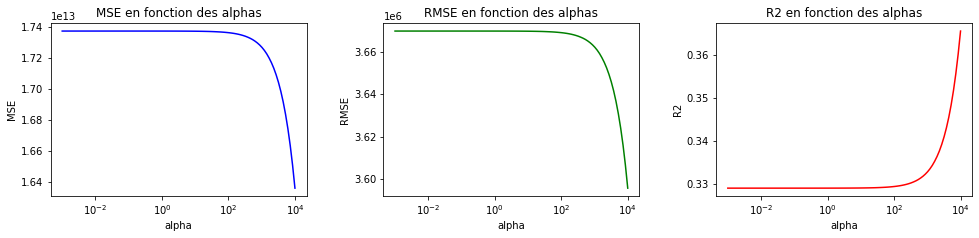

In [24]:
fig, axes = plt.subplots(1, 3,figsize=(16,3))
tab = ['MSE','RMSE','R2']
color = ['b','g','r']

for i,error_name in enumerate(tab) :
    error_liste = [name[i+1] for j,name in enumerate(TabErrors)]
    axes[i].plot(alphas,  error_liste,c=color[i])
    axes[i].set_xscale('log')
    axes[i].set_xlabel('alpha')
    axes[i].set_ylabel(error_name)
    axes[i].set_title(tab[i] + ' en fonction des alphas')
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, 
                    wspace=0.3, hspace=0.2)

plt.show()

In [25]:
dfErrors = pd.DataFrame(TabErrors,columns=['alpha','MSE','RMSE','R2'])
imin = dfErrors['R2'].idxmax()
print('Index values for MSE {}, RMSE {},  R2 {}'
      .format(dfErrors['MSE'].idxmax(),dfErrors['MSE'].idxmax(),imin  )   )
alphaBest = dfErrors.loc[imin,'alpha']
print('Best fit is for alpha = {}'.format(alphaBest))

Index values for MSE 0, RMSE 0,  R2 99
Best fit is for alpha = 10000.0


In [26]:
lasso_regr.set_params(alpha=alphaBest)
lasso_regr.fit(xTrainScaled, yTrain)
yPredTrain = lasso_regr.predict(xTrainScaled)
yPredTest = lasso_regr.predict(xTestScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 5432438743785.87 RMSE 2330759.26 R2 0.778
MSE 6458743204613.76 RMSE 2541405.75 R2 0.758


In [27]:
# Store errors
Results.append(['Lasso with Manual CV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Decision Tree Regressor

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

fold_number = 5
param_grid={"max_depth" : [3,4,5,6],
                "min_samples_leaf":[2,3,4,5,10],
                "min_samples_split":[10,20,30,40]
               # "max_features":[2,3,4]
               }
                    
dtr = DecisionTreeRegressor()
grid_search = GridSearchCV(dtr, param_grid,
              scoring='r2', cv=fold_number)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9738977511575719

In [29]:
grid_search.score(xTrainScaled, yTrain).round(3)

0.986

In [30]:
grid_search.best_params_

{'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 20}

In [31]:
best_depth = grid_search.best_params_['max_depth']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']

In [32]:
dtr = DecisionTreeRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
                                         min_samples_split= best_min_samples_split)
dtr.fit(xTrainScaled, yTrain)
yPredTrain = dtr.predict(xTrainScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
yPredTest = dtr.predict(xTestScaled)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 341391908503.78 RMSE 584287.52 R2 0.986
MSE 984645657636.12 RMSE 992293.13 R2 0.963


In [33]:
# Store errors
Results.append(['Decision Tree Regressor',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor

fold_number = 5
param_grid={"max_depth" : [2,4,5],
                "min_samples_leaf":[2,5],
                "min_samples_split":[10,20],
                "n_estimators":[100,300,500],
                #"max_leaf_nodes":[16]
               # "max_features":[2,3,4]
               }
                    
rfg = RandomForestRegressor()
grid_search = GridSearchCV(rfg, param_grid,
              scoring='r2', cv=fold_number,n_jobs=-1)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9793130481097851

In [35]:
grid_search.score(xTrainScaled, yTrain).round(3)

0.988

In [36]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 500}

In [37]:
best_depth = grid_search.best_params_['max_depth']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']
#best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
best_n_estimators = grid_search.best_params_['n_estimators']

In [38]:
#rfg = RandomForestRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
 #                                         max_leaf_nodes = best_max_leaf_nodes, min_samples_split= best_min_samples_split,
  #                                        n_estimators = best_n_estimators)
rfg = RandomForestRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
                                           min_samples_split= best_min_samples_split,
                                          n_estimators = best_n_estimators)

rfg.fit(xTrainScaled, yTrain)
yPredTrain = rfg.predict(xTrainScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
yPredTest = rfg.predict(xTestScaled)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 283143131453.83 RMSE 532111.95 R2 0.988
MSE 814773631035.78 RMSE 902648.12 R2 0.970


In [39]:
# Store errors
Results.append(['Random Forest',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Gradient Boosting

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

fold_number = 5
param_grid={"max_depth" : [4,6],
            #"min_samples_leaf":[5,10],
            "min_samples_split":[10,20],
            "n_estimators":[300,600],
            #"max_leaf_nodes":[16],
            "learning_rate":[0.05,0.1],
            "n_iter_no_change":[10]
            
            # "max_features":[2,3,4]
               }
                    
gbr = GradientBoostingRegressor()
grid_search = GridSearchCV(gbr, param_grid,
              scoring='r2', cv=fold_number,n_jobs=-1)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9861965889356575

In [41]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 4,
 'min_samples_split': 20,
 'n_estimators': 600,
 'n_iter_no_change': 10}

In [42]:
best_depth = grid_search.best_params_['max_depth']
#best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']
#best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
best_n_estimators = grid_search.best_params_['n_estimators']
best_learning_rate = grid_search.best_params_['learning_rate']
best_n_iter_no_change = grid_search.best_params_['n_iter_no_change']

In [43]:
#gbr = GradientBoostingRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
                             #   max_leaf_nodes = best_max_leaf_nodes, min_samples_split= best_min_samples_split,
                             #   n_estimators = best_n_estimators, learning_rate = best_learning_rate,
                             #   n_iter_no_change = best_n_iter_no_change)
gbr = GradientBoostingRegressor(max_depth=best_depth,
                                 min_samples_split= best_min_samples_split,
                                n_estimators = best_n_estimators, learning_rate = best_learning_rate,
                                 n_iter_no_change = best_n_iter_no_change)

gbr.fit(xTrainScaled, yTrain)
yPredTrain = gbr.predict(xTrainScaled)
yPredTest = gbr.predict(xTestScaled)

msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 80526099816.53 RMSE 283771.21 R2 0.997
MSE 654869698556.33 RMSE 809240.20 R2 0.975


In [44]:
# Store errors
Results.append(['Gradient Boosting',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Comparaison des différents algorithmes

In [46]:
dfResults = pd.DataFrame(Results,columns=['Name','MSE Train','RMSE Train','R2 Train','MSE Test','RMSE Test','R2 Test'])
dfResults.round(3)

,Name,MSE Train,RMSE Train,R2 Train,MSE Test,RMSE Test,R2 Test
0,Linear Regression,5.427739e+12,2329750.789,0.778,6.490946e+12,2547733.520,0.757
1,RidgeCV,6.193806e+12,2488735.827,0.747,8.338294e+12,2887610.364,0.688
2,Ridge with Manual CV,6.193806e+12,2488735.827,0.747,8.338294e+12,2887610.364,0.688
3,LassoCV,5.727647e+12,2393250.262,0.766,6.678013e+12,2584185.080,0.750
4,Lasso with Manual CV,5.432439e+12,2330759.263,0.778,6.458743e+12,2541405.754,0.758
5,Decision Tree Regressor,3.413919e+11,584287.522,0.986,9.846457e+11,992293.131,0.963
6,Random Forest,2.831431e+11,532111.954,0.988,8.147736e+11,902648.121,0.970
7,Gradient Boosting,8.052610e+10,283771.210,0.997,6.548697e+11,809240.198,0.975


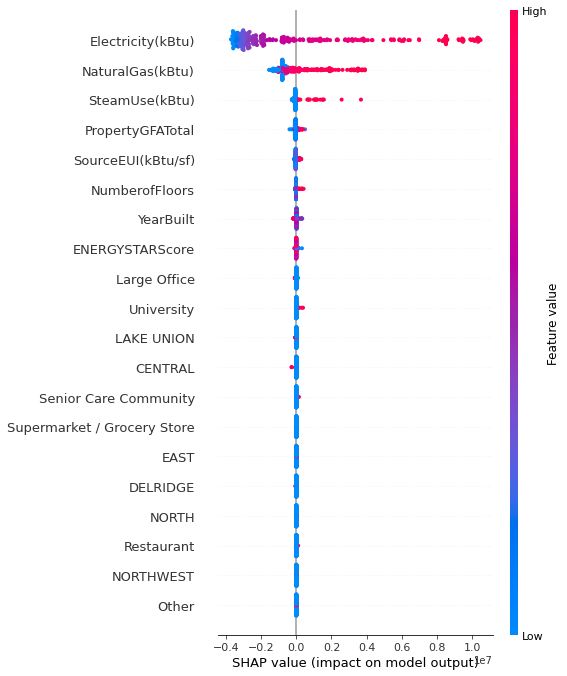

In [47]:
shap_values = shap.TreeExplainer(gbr).shap_values(xTestScaled)
shap.summary_plot(shap_values, xTestScaled,use_log_scale=False,feature_names=XTest.columns)

### 3. Modélisations sans l'Energy Star Score

In [48]:
XTrain = dfTrain.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'],axis=1 )
yTrain = dfTrain[targetName].copy()
XTest = dfTest.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'],axis=1 )
yTest = dfTest[targetName].copy()

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

xTrainScaled = scaler.fit_transform(XTrain)
xTestScaled = scaler.transform(XTest)

#### Linear Regression

In [50]:
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression()
linear_regr.fit(xTrainScaled, yTrain)

yPredTrain = linear_regr.predict(xTrainScaled)
yPredTest = linear_regr.predict(xTestScaled)

In [51]:
msTrain,rmTrain,r2Train  = getRegressionMetrics(yPredTrain, yTrain)
msTest,rmTest,r2Test  = getRegressionMetrics(yPredTest, yTest)

MSE 5436203230545.15 RMSE 2331566.69 R2 0.778
MSE 6498793646832.15 RMSE 2549273.16 R2 0.757


In [52]:
# Store errors
Results = []
Results.append(['Linear Regression',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### RidgeCV

In [53]:
from sklearn.linear_model import RidgeCV

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

ridgeCV_regr = RidgeCV(alphas=alphas,
scoring='neg_mean_squared_error',
                 cv=fold_number)
ridgeCV_regr.fit(xTrainScaled, yTrain)
print('alpha = {}  best score = {}'.format(ridgeCV_regr.alpha_ , ridgeCV_regr.best_score_))
yPredtrain = ridgeCV_regr.predict(xTrainScaled)
print('Train best score = {}'.format(ridgeCV_regr.score(xTrainScaled,yTrain)))
yPredTest = ridgeCV_regr.predict(xTestScaled)
print('Test best score = {}'.format(ridgeCV_regr.score(xTestScaled,yTest)))
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredtrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

alpha = 599.4842503189409  best score = -7382964179665.4795
Train best score = 0.7470865274512718
Test best score = 0.6875151017519001
MSE 6182109886500.52 RMSE 2486384.90 R2 0.747
MSE 8349068646286.69 RMSE 2889475.50 R2 0.688


In [54]:
# Store errors
Results.append(['RidgeCV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Ridge  with Manual CV

In [55]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from numpy import mean , std

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

In [56]:
TabErrors = []
ridge_regr = Ridge()

for i,a in enumerate(alphas) :
    ridge_regr.set_params(alpha=a)
    scores = cross_validate(ridge_regr, xTrainScaled, yTrain, cv=fold_number,
                            scoring=('neg_mean_squared_error','neg_root_mean_squared_error','r2'))
    temp = a, -mean(scores['test_neg_mean_squared_error']), -mean(scores['test_neg_root_mean_squared_error']), mean(scores['test_r2'])
    TabErrors.append(temp)

#mini = [val[0] for i,val in enumerate(TabErrors) if val[1] == np.min(TabErrors,axis=0)[1]]
#mini

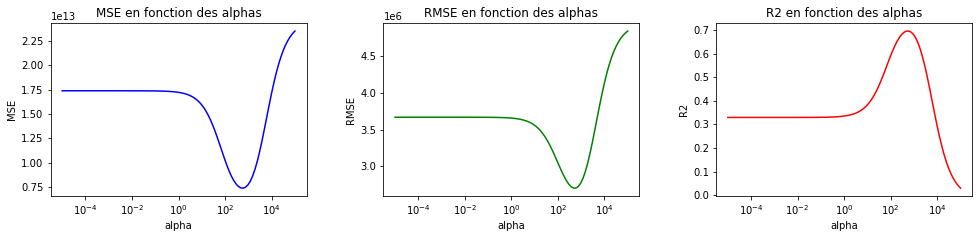

In [57]:
fig, axes = plt.subplots(1, 3,figsize=(16,3))
tab = ['MSE','RMSE','R2']
color = ['b','g','r']

for i,error_name in enumerate(tab) :
    error_liste = [name[i+1] for j,name in enumerate(TabErrors)]
    axes[i].plot(alphas,  error_liste,c=color[i])
    axes[i].set_xscale('log')
    axes[i].set_xlabel('alpha')
    axes[i].set_ylabel(error_name)
    axes[i].set_title(tab[i] + ' en fonction des alphas')
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, 
                    wspace=0.3, hspace=0.2)

plt.show()

Get best params

In [58]:
dfErrors = pd.DataFrame(TabErrors,columns=['alpha','MSE','RMSE','R2'])
imin = dfErrors['R2'].idxmax()
print('Index values for MSE {}, RMSE {},  R2 {}'
      .format(dfErrors['MSE'].idxmax(),dfErrors['MSE'].idxmax(),imin  )   )
alphaBest = dfErrors.loc[imin,'alpha']
print('Best fit is for alpha = {}'.format(alphaBest))

Index values for MSE 99, RMSE 99,  R2 77
Best fit is for alpha = 599.4842503189409


Apply model with best params

In [59]:
ridge_regr.set_params(alpha=alphaBest)
ridge_regr.fit(xTrainScaled, yTrain)
yPredTrain = ridge_regr.predict(xTrainScaled)
yPredTest = ridge_regr.predict(xTestScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 6182109886500.52 RMSE 2486384.90 R2 0.747
MSE 8349068646286.69 RMSE 2889475.50 R2 0.688


In [60]:
# Store errors
Results.append(['Ridge with Manual CV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### LassoCV

In [61]:
from sklearn.linear_model import LassoCV

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

lassoCV_regr = LassoCV(alphas=alphas, cv=fold_number)

lassoCV_regr.fit(xTrainScaled, yTrain)
print('Best fit is for alpha = {}'.format(lassoCV_regr.alpha_))
yPredtrain = lassoCV_regr.predict(xTrainScaled)
print('Train best score = {:.3f}'.format(lassoCV_regr.score(xTrainScaled,yTrain)))
yPredTest = lassoCV_regr.predict(xTestScaled)
print('Test best score = {:.3f}'.format(lassoCV_regr.score(xTestScaled,yTest)))
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredtrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

Best fit is for alpha = 100000.0
Train best score = 0.766
Test best score = 0.750
MSE 5727652472629.83 RMSE 2393251.44 R2 0.766
MSE 6678028438112.83 RMSE 2584188.16 R2 0.750


In [62]:
# Store errors
Results.append(['LassoCV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Lasso with Manual CV

In [63]:
from sklearn.linear_model import Lasso

n_alphas = 100
alphas = np.logspace(-3, 4, n_alphas)

In [64]:
TabErrors = []
lasso_regr = Lasso()

for i,a in enumerate(alphas) :
    lasso_regr.set_params(alpha=a)
    scores = cross_validate(lasso_regr, xTrainScaled, yTrain, cv=fold_number,
                            scoring=('neg_mean_squared_error','neg_root_mean_squared_error','r2'))
    temp = a, -mean(scores['test_neg_mean_squared_error']), -mean(scores['test_neg_root_mean_squared_error']), mean(scores['test_r2'])
    TabErrors.append(temp)


Objective did not converge. You might want to increase the number of iterations. Duality gap: 130336640031209.0, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 374441957305303.5, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 397897735783717.0, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 122784391064317.0, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 404270766263780.5, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 130336651353654.0, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 374441969380283.5, tolerance: 2632331717772.0674


Objective did not converge. You might want to increase the number of iterations. Duality gap: 374442039948302.0, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 397897844874535.5, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 122784426899174.5, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 404270811484543.0, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 130336649218621.5, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 374442041215748.5, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 397897847669386.5, tolerance: 2693593624520.2476


Objective did not converge. You might want to increase the number of iterations. Duality gap: 130336777612939.5, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 374442248638831.0, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 397898058800948.0, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 122784570105377.5, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 404271043457912.0, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 130336802540285.0, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 374442291792647.5, tolerance: 2632331717772.0674


Objective did not converge. You might want to increase the number of iterations. Duality gap: 122785358586552.0, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 404272402522939.5, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 130337702659572.5, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 374443767258278.5, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 397899555347801.0, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 122785525954694.5, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 404272690834756.5, tolerance: 2559013009949.358
O

Objective did not converge. You might want to increase the number of iterations. Duality gap: 374452585299649.0, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 397908242241670.0, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 122791082331623.0, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 404282260968441.0, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 130344510696551.5, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 374454453430203.5, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 397910080589050.5, tolerance: 2693593624520.2476


Objective did not converge. You might want to increase the number of iterations. Duality gap: 404350862401565.5, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 130390358806565.0, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 288599775265988.5, tolerance: 2632331717772.0674
Objective did not converge. You might want to increase the number of iterations. Duality gap: 285669927590245.0, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 122838980270755.0, tolerance: 2484634878793.5884
Objective did not converge. You might want to increase the number of iterations. Duality gap: 404364789039846.5, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 130399790530434.0, tolerance: 2530144540971.3906
O

Objective did not converge. You might want to increase the number of iterations. Duality gap: 41752896816158.0, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6369958184722.0, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 130833037648017.0, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 41789908098959.0, tolerance: 2693593624520.2476
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6386362351668.0, tolerance: 2559013009949.358
Objective did not converge. You might want to increase the number of iterations. Duality gap: 14355163873072.0, tolerance: 2530144540971.3906
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6405609055646.0, tolerance: 2559013009949.358
Objective d

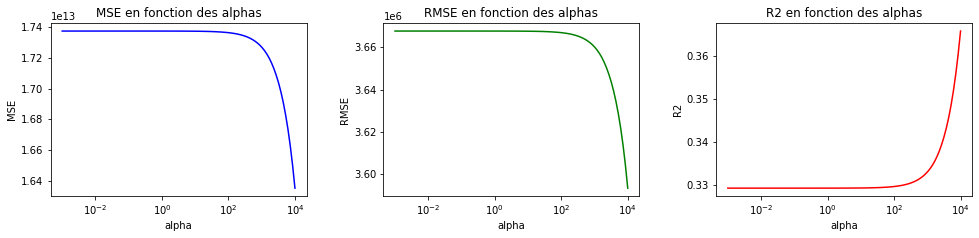

In [65]:
fig, axes = plt.subplots(1, 3,figsize=(16,3))
tab = ['MSE','RMSE','R2']
color = ['b','g','r']

for i,error_name in enumerate(tab) :
    error_liste = [name[i+1] for j,name in enumerate(TabErrors)]
    axes[i].plot(alphas,  error_liste,c=color[i])
    axes[i].set_xscale('log')
    axes[i].set_xlabel('alpha')
    axes[i].set_ylabel(error_name)
    axes[i].set_title(tab[i] + ' en fonction des alphas')
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, 
                    wspace=0.3, hspace=0.2)

plt.show()

In [66]:
dfErrors = pd.DataFrame(TabErrors,columns=['alpha','MSE','RMSE','R2'])
imin = dfErrors['R2'].idxmax()
print('Index values for MSE {}, RMSE {},  R2 {}'
      .format(dfErrors['MSE'].idxmax(),dfErrors['MSE'].idxmax(),imin  )   )
alphaBest = dfErrors.loc[imin,'alpha']
print('Best fit is for alpha = {}'.format(alphaBest))

Index values for MSE 0, RMSE 0,  R2 99
Best fit is for alpha = 10000.0


In [67]:
lasso_regr.set_params(alpha=alphaBest)
lasso_regr.fit(xTrainScaled, yTrain)
yPredTrain = lasso_regr.predict(xTrainScaled)
yPredTest = lasso_regr.predict(xTestScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 5440524376200.72 RMSE 2332493.17 R2 0.777
MSE 6468266412807.37 RMSE 2543278.67 R2 0.758


In [68]:
# Store errors
Results.append(['Lasso with Manual CV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Decision Tree Regressor

In [69]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

fold_number = 5
param_grid={"max_depth" : [2,3,4,5,6],
                "min_samples_leaf":[2,3,4,5,10],
                "min_samples_split":[10,15,20,25,30,40]
               # "max_features":[2,3,4]
               }
                    
dtr = DecisionTreeRegressor()
grid_search = GridSearchCV(dtr, param_grid,
              scoring='r2', cv=fold_number)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9754127709469091

In [70]:
grid_search.score(xTrainScaled, yTrain).round(3)

0.987

In [71]:
best_depth = grid_search.best_params_['max_depth']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']

In [72]:
dtr = DecisionTreeRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
                                         min_samples_split= best_min_samples_split)
dtr.fit(xTrainScaled, yTrain)
yPredTrain = dtr.predict(xTrainScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
yPredTest = dtr.predict(xTestScaled)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 317339425191.71 RMSE 563328.88 R2 0.987
MSE 988629601470.34 RMSE 994298.55 R2 0.963


In [73]:
# Store errors
Results.append(['Decision Tree Regressor',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Random Forest

In [74]:
from sklearn.ensemble import RandomForestRegressor

fold_number = 5
param_grid={"max_depth" : [2,4,5],
                "min_samples_leaf":[2,5],
                "min_samples_split":[10,20],
                "n_estimators":[100,300,500],
                #"max_leaf_nodes":[16]
               # "max_features":[2,3,4]
               }
                    
rfg = RandomForestRegressor()
grid_search = GridSearchCV(rfg, param_grid,
              scoring='r2', cv=fold_number,n_jobs=-1)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9794440538441387

In [75]:
grid_search.score(xTrainScaled, yTrain).round(3)

0.988

In [76]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 300}

In [77]:
best_depth = grid_search.best_params_['max_depth']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']
#best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
best_n_estimators = grid_search.best_params_['n_estimators']

In [78]:
rfg = RandomForestRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
                            min_samples_split= best_min_samples_split, n_estimators = best_n_estimators)
rfg.fit(xTrainScaled, yTrain)
yPredTrain = rfg.predict(xTrainScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
yPredTest = rfg.predict(xTestScaled)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 290051388692.87 RMSE 538564.19 R2 0.988
MSE 843256330523.15 RMSE 918289.89 R2 0.968


In [79]:
# Store errors
Results.append(['Random Forest',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Gradient Boosting

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

fold_number = 5
param_grid={"max_depth" : [4,6],
            #"min_samples_leaf":[5,10],
            "min_samples_split":[10,20],
            "n_estimators":[300,600],
            #"max_leaf_nodes":[16],
            "learning_rate":[0.05,0.1],
            "n_iter_no_change":[10]
            
            # "max_features":[2,3,4]
               }
                    
gbr = GradientBoostingRegressor()
grid_search = GridSearchCV(gbr, param_grid,
              scoring='r2', cv=fold_number,n_jobs=-1)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9860320003806331

In [81]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 4,
 'min_samples_split': 10,
 'n_estimators': 600,
 'n_iter_no_change': 10}

In [82]:
best_depth = grid_search.best_params_['max_depth']
#best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']
#best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
best_n_estimators = grid_search.best_params_['n_estimators']
best_learning_rate = grid_search.best_params_['learning_rate']
best_n_iter_no_change = grid_search.best_params_['n_iter_no_change']

In [83]:
gbr = GradientBoostingRegressor(max_depth=best_depth,min_samples_split= best_min_samples_split,
                                n_estimators = best_n_estimators, learning_rate = best_learning_rate,
                                 n_iter_no_change = best_n_iter_no_change)
gbr.fit(xTrainScaled, yTrain)
yPredTrain = gbr.predict(xTrainScaled)
yPredTest = gbr.predict(xTestScaled)

msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 87038068489.61 RMSE 295022.15 R2 0.996
MSE 645568072197.25 RMSE 803472.51 R2 0.976


In [84]:
# Store errors
Results.append(['Gradient Boosting',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Comparaison des différents algorithmes

In [85]:
dfResults = pd.DataFrame(Results,columns=['Name','MSE Train','RMSE Train','R2 Train','MSE Test','RMSE Test','R2 Test'])
dfResults.round(3)

,Name,MSE Train,RMSE Train,R2 Train,MSE Test,RMSE Test,R2 Test
0,Linear Regression,5.436203e+12,2331566.690,0.778,6.498794e+12,2549273.160,0.757
1,RidgeCV,6.182110e+12,2486384.903,0.747,8.349069e+12,2889475.497,0.688
2,Ridge with Manual CV,6.182110e+12,2486384.903,0.747,8.349069e+12,2889475.497,0.688
3,LassoCV,5.727652e+12,2393251.444,0.766,6.678028e+12,2584188.158,0.750
4,Lasso with Manual CV,5.440524e+12,2332493.167,0.777,6.468266e+12,2543278.674,0.758
5,Decision Tree Regressor,3.173394e+11,563328.878,0.987,9.886296e+11,994298.547,0.963
6,Random Forest,2.900514e+11,538564.192,0.988,8.432563e+11,918289.895,0.968
7,Gradient Boosting,8.703807e+10,295022.149,0.996,6.455681e+11,803472.509,0.976


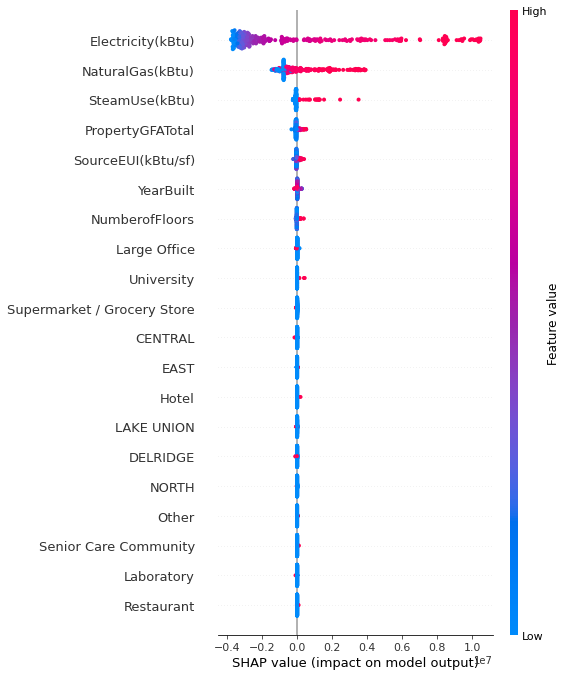

In [87]:
shap_values = shap.TreeExplainer(gbr).shap_values(xTestScaled)
shap.summary_plot(shap_values, xTestScaled,use_log_scale=False,feature_names=XTest.columns)